# Loading & Preprocessing

In [1]:
import json
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications import DenseNet201
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from keras import backend as K
import gc
from sklearn import metrics
import json
import itertools

%matplotlib inline

In [2]:
#Transfer 'jpg' images to an array IMG_ARR
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG_ARR = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
            img = cv2.resize(img, (RESIZE,RESIZE))
            IMG_ARR.append(np.array(img))
    return IMG_ARR

benign_train = np.array(Dataset_loader('data/train/benign',224))
malign_train = np.array(Dataset_loader('data/train/malignant',224))
benign_test = np.array(Dataset_loader('data/validation/benign',224))
malign_test = np.array(Dataset_loader('data/validation/malignant',224))

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 16.94it/s]


# Create Label

In [3]:
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

# Train and Evalutation split

In [4]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=0
)

# Display Some Images

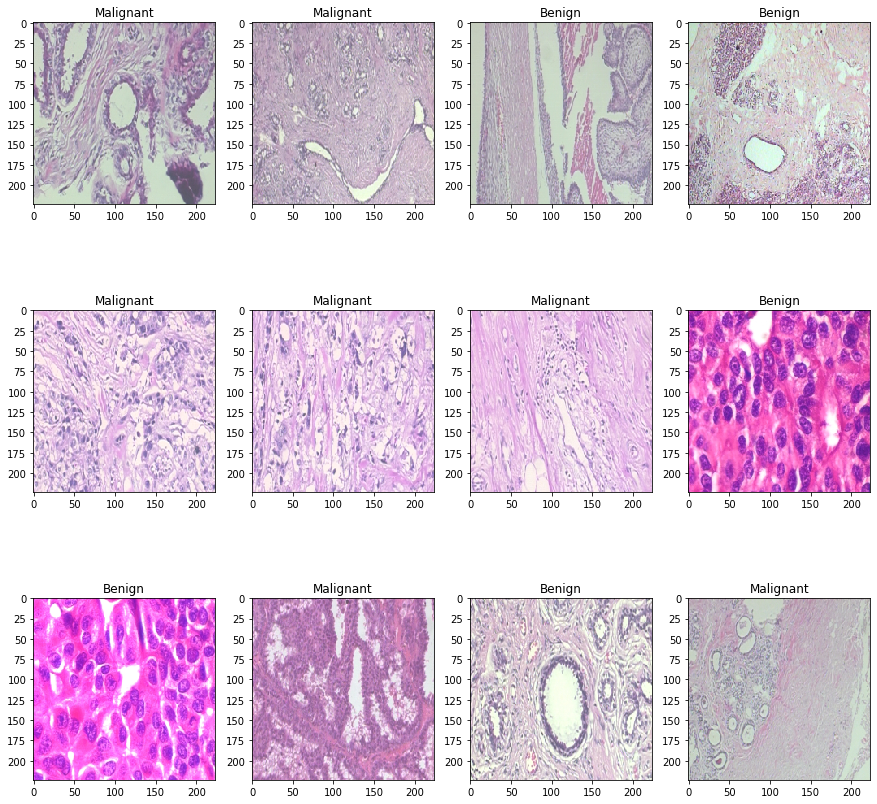

In [5]:

# # Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

# Data Generator

In [6]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Model: ResNet50

In [7]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(64,activation='relu')) #64 neuron hidden layer
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [8]:
K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)


 


model = build_model(resnet ,lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 64)                122944    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

c:\python\python38\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Training & Evaluation

In [10]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/20
20/20 [==============================] - 324s 12s/step - loss: 0.7103 - accuracy: 0.6031 - val_loss: 0.5854 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 2/20
20/20 [==============================] - 217s 11s/step - loss: 0.5394 - accuracy: 0.7594 - val_loss: 0.4815 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 3/20
20/20 [==============================] - 215s 11s/step - loss: 0.4156 - accuracy: 0.8438 - val_loss: 0.4446 - val_accuracy: 0.7375 - lr: 1.0000e-04
Epoch 4/20
20/20 [==============================] - 213s 11s/step - loss: 0.2725 - accuracy: 0.9062 - val_loss: 0.7704 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 5/20
20/20 [==============================] - 214s 11s/step - loss: 0.2261 - accuracy: 0.9187 - val_loss: 1.3676 - val_accuracy: 0.5875 - lr: 1.0000e-04
Epoch 6/20
20/20 [==============================] - 212s 11s/step - loss: 0.1536 - accuracy: 0.9531 - val_loss: 0.8196 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 7/20
20/20 [============================

Epoch 18/20
20/20 [==============================] - 210s 11s/step - loss: 0.0813 - accuracy: 0.9750 - val_loss: 0.0241 - val_accuracy: 0.9875 - lr: 1.0000e-04
Epoch 19/20
20/20 [==============================] - 210s 11s/step - loss: 0.0924 - accuracy: 0.9719 - val_loss: 0.0143 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 20/20
20/20 [==============================] - 216s 11s/step - loss: 0.0811 - accuracy: 0.9719 - val_loss: 0.0092 - val_accuracy: 1.0000 - lr: 1.0000e-04


In [11]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

<AxesSubplot:>

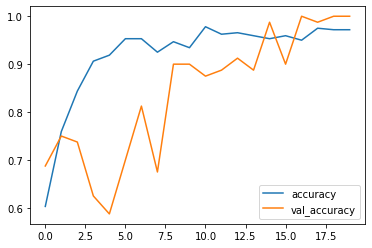

In [12]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

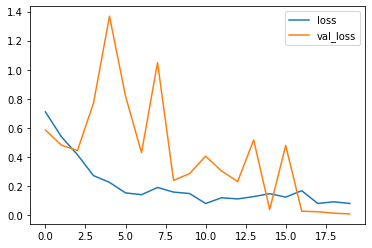

In [13]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# Prediction

In [44]:
model.load_weights("weights.best.hdf5")

OSError: Unable to open file (unable to open file: name = 'weights.best.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [14]:
Y_val_pred = model.predict(x_val)

In [15]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

1.0

In [16]:
Y_pred = model.predict(X_test)

In [17]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:07<00:00, 12.73s/it]




### Confusion Matrix

Confusion matrix, without normalization
[[35 15]
 [ 0 50]]


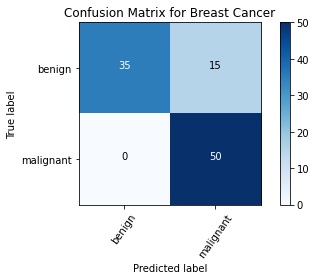

In [18]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Matrix for Breast Cancer')

Confusion matrix, without normalization
[[35 15]
 [ 0 50]]


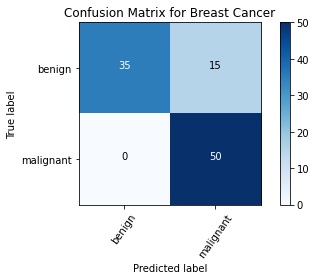

In [19]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Matrix for Breast Cancer')

### Classification Report

In [20]:
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

'              precision    recall  f1-score   support\n\n           0       1.00      0.70      0.82        50\n           1       0.77      1.00      0.87        50\n\n    accuracy                           0.85       100\n   macro avg       0.88      0.85      0.85       100\nweighted avg       0.88      0.85      0.85       100\n'

### ROC and AUC

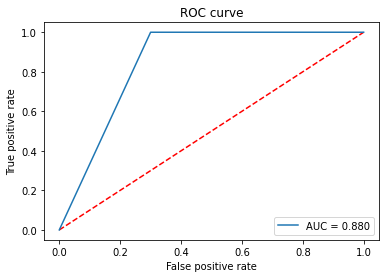

In [25]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = 0.880'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

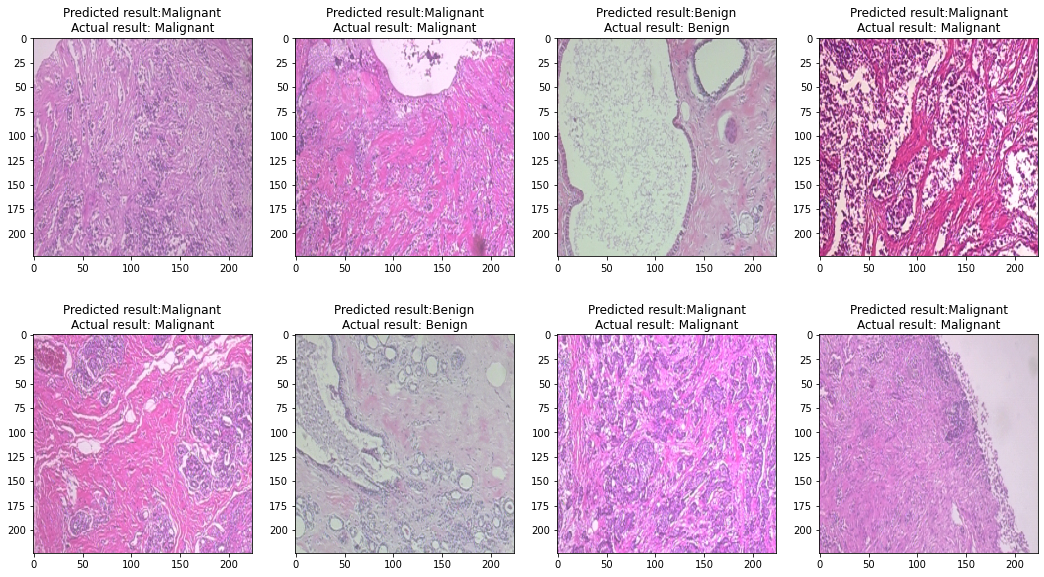

In [22]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()